<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/notebooks/anaytic_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 215 (delta 10), reused 11 (delta 4), pack-reused 191
Receiving objects: 100% (215/215), 21.48 MiB | 32.39 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [0]:
from google.colab import files

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import seaborn as sns
sns.set()

In [0]:
from collections import OrderedDict

In [0]:
import sys
sys.path.append("../")
from Neural_Tangent_Kernel.src.NTK_net import LinearNeuralTangentKernel, FourLayersNet, train_net, circle_transform, variance_est, cpu_tuple

In [0]:
use_cuda = True if torch.cuda.is_available() else False


# Reproducing the experiments in the neural tangent kernel paper.



## 6.2



### Define the input and target data

In [0]:
gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()
input_data = circle_transform(gamma_data)
if use_cuda:
  input_data = input_data.cuda()
  target_data = target_data.cuda()

### Create Plot

In [0]:
gamma_vec = torch.tensor(np.linspace(-np.pi, np.pi, 100))
circle_points = circle_transform(gamma_vec)
if use_cuda:
  circle_points = circle_points.cuda()

Completed initialisation 0
Completed initialisation 1
Completed initialisation 2
Completed initialisation 3
Completed initialisation 4
Completed initialisation 5
Completed initialisation 6
Completed initialisation 7
Completed initialisation 8
Completed initialisation 9


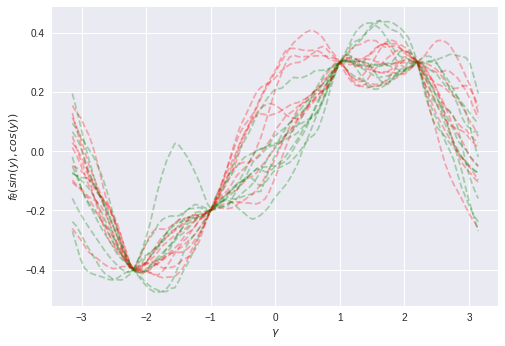

In [0]:
for i in range(10):
  # 1000 width first
  net = FourLayersNet(1000)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='red',
           linestyle='--', alpha = 0.3)
  # 50 width
  net = FourLayersNet(50)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='green',
           linestyle='--', alpha = 0.3)
  
  print('Completed initialisation {}'.format(i))
  
plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
plt.show()
   
   

### Getting the GP process plot is harder (I think) because of a lack of a standard kernel, here is an attempt but it is probably horrifically inefficient

In [0]:
n_pts=100
n_width = 10000

In [0]:
# number of points in plot
grad_mat = torch.zeros((n_pts,4))
net = FourLayersNet(n_width)
if use_cuda:
  net.cuda()

In [0]:
gamma_test = torch.tensor(np.linspace(-np.pi,np.pi, n_pts))
initial_train = net(input_data) # this acts of f_0 on page 7 of NTK paper
initial_test = net(circle_transform(gamma_test).cuda())

In [0]:
#train_net(net, 1000, input_data, target_data)

In [0]:
grad_list = []
for gamma in gamma_data:
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grad_list.append(cpu_tuple(torch.autograd.grad(loss,net.parameters(), retain_graph = True)))

In [0]:
%%time
# grad_mat is kappa on p7 of NTK paper
for i, gamma in enumerate(gamma_test):
  if i%10 == 0:
    print('point {}'.format(i))
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grads = cpu_tuple(torch.autograd.grad(loss,net.parameters(), retain_graph = True)) # extract NN gradients 
  for j in range(len(grad_list)):
    pt_grad = grad_list[j] # the gradients at the jth (out of 4) data point
    grad_mat[i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])

point 0
point 10
point 20
point 30
point 40
point 50
point 60
point 70
point 80
point 90
CPU times: user 3min 4s, sys: 5.33 s, total: 3min 9s
Wall time: 3min 9s


In [0]:
# let's create Ktilde matrix from p7 of NTK paper
tilde_mat = torch.zeros((4,4))
for i in range(4):
  grad_i = grad_list[i]
  for j in range(i+1):
    grad_j = grad_list[j]
    tilde_mat[i, j] = sum([torch.sum(torch.mul(grad_i[u], grad_j[u])) for u in range(len(grad_j))])
    tilde_mat[j, i] = tilde_mat[i, j]
    
tilde_inv = torch.inverse(tilde_mat)

In [0]:
temp_mat = torch.mm(grad_mat, tilde_inv)

In [0]:
target_data = target_data.cpu()

In [0]:
mean_vec = torch.mm(temp_mat, target_data.unsqueeze(1)) #+ initial_test.cpu() - torch.mm(temp_mat, initial_train.cpu())
np.save('mean_vec.npy', mean_vec.numpy())
files.download('mean_vec.npy')

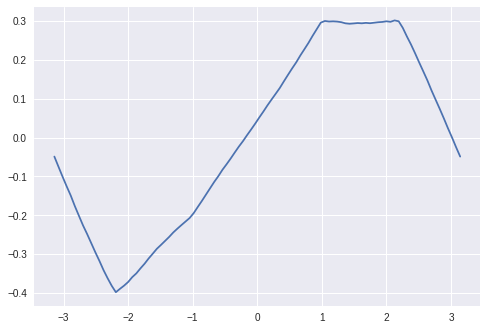

In [0]:
plt.plot(gamma_test.numpy(), mean_vec.detach().numpy())

### It remains to estimate sigma matrix

In [0]:
variance_vec = variance_est(10000, 100, temp_mat, 10000)

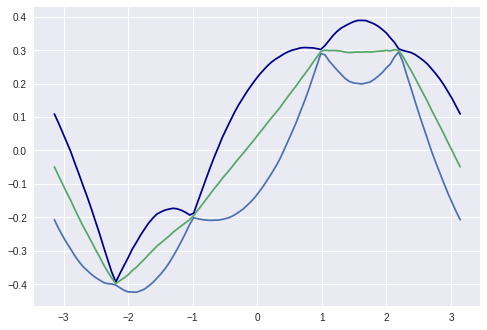

In [0]:
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+1.28*np.sqrt(variance_vec.detach().numpy()), color = 'darkblue')
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-1.28*np.sqrt(variance_vec.detach().numpy()))
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*np.sqrt(variance_vec.detach().numpy()))



Completed initialisation 0
Completed initialisation 1
Completed initialisation 2
Completed initialisation 3
Completed initialisation 4
Completed initialisation 5
Completed initialisation 6
Completed initialisation 7
Completed initialisation 8
Completed initialisation 9


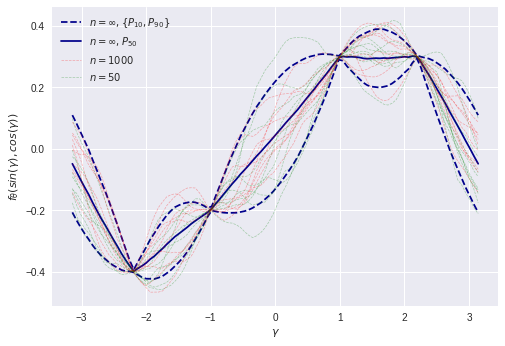

In [0]:
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+1.28*np.sqrt(variance_vec.detach().numpy()),
         color='darkblue', linestyle = '--')
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-1.28*np.sqrt(variance_vec.detach().numpy()), 
         color='darkblue', linestyle = '--', label = '$n=\infty, \{P_{10}, P_{90}\}$')
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*np.sqrt(variance_vec.detach().numpy()), 
         color='darkblue', label = '$n=\infty, P_{50}$')

for i in range(10):
  # 1000 width first
  net = FourLayersNet(1000)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data.cuda())
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='red',
           linestyle='--', alpha = 0.3, label = '$n=1000$', linewidth = 0.7)
 # 50 width
  net = FourLayersNet(50)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data.cuda())
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='green',
           linestyle='--', alpha = 0.3,  label = '$n=50$', linewidth = 0.7)
  
  print('Completed initialisation {}'.format(i))

plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.savefig('6pt2.pdf')
files.download('6pt2.pdf')
plt.show()

**Analytic Kernel function (should be added to the script instead)**

In [0]:
class DeepArcCosine(object):

    def __init__(self, input_dim, num_steps,
                 variance=1.0, bias_variance=0., active_dims=None):
        #gpflow.kernels.Kern.__init__(self, input_dim, active_dims)
        self.input_dim =input_dim
        self.num_steps = num_steps
        self.bias_variance=bias_variance
        self.variance=variance
        #self.variance = gpflow.param.Param(variance, gpflow.transforms.positive)
        #self.bias_variance = gpflow.param.Param(bias_variance, gpflow.transforms.positive)
    
    def baseK(self, X, X2):
        inner = torch.matmul(X * self.variance, X2.t())/self.input_dim 
        return inner + torch.ones_like(inner) * self.bias_variance
        
    def baseKdiag(self, X):
        inner = torch.sum(torch.mul(X,X) * self.variance, 1)/self.input_dim
        return inner + torch.ones_like(inner) * self.bias_variance
        
    def K(self, X, X2=None):
        # the linear kernel
        if X2 is None:
            X2 = X
        K = self.baseK( X, X2 )
        kxdiag  = self.baseKdiag(X)
        kx2diag = self.baseKdiag(X2) 

        for step_index in range(self.num_steps):
            # recursively compute (scaled) relu kernel
            K = self.recurseK( K, kxdiag, kx2diag )
            kxdiag = self.recurseKdiag( kxdiag )
            kx2diag = self.recurseKdiag( kx2diag )

        return K

    def Kdiag(self, X):
        Kdiag = self.baseKdiag( X )

        for step_index in range(self.num_steps):
            Kdiag = self.recurseKdiag( Kdiag )

        return Kdiag

    def recurseK(self, K, kxdiag, kx2diag):
        norms = torch.sqrt(kxdiag)
        norms_rec = torch.rsqrt(kxdiag)
        norms2 = torch.sqrt(kx2diag)
        norms2_rec = torch.rsqrt(kx2diag)
        
        jitter = 1e-7
        scaled_numerator = K * (1.-jitter)
        
                
        cos_theta = scaled_numerator * norms_rec[:,None] *  norms2_rec[None,:]
        theta = torch.acos(cos_theta) 
        return self.variance / np.pi * (torch.sqrt(kxdiag[:,None] * kx2diag[None,:] - torch.mul(scaled_numerator,scaled_numerator) ) + (np.pi - theta) * scaled_numerator ) + self.bias_variance*torch.ones_like(K)
    
    def recurseKdiag(self, Kdiag):
        # angle is zero, hence the diagonal stays the same (if scaled relu is used)        
        return self.variance * Kdiag  + self.bias_variance * torch.ones_like(Kdiag)  

**Test the function**

In [0]:
bias_variance = 0.5
variance = 0.7
num_hidden_layers = 4
print("\n Test one dim: \n")
input_dim = 1
X = torch.from_numpy(np.atleast_2d( np.linspace( -0.5 , 0.5 , 4 ) ).T)
test_kernel = DeepArcCosine(input_dim = input_dim, num_steps = num_hidden_layers, variance=variance, bias_variance = bias_variance)
a=test_kernel.K(X,X)
print(a)


 Test one dim: 

tensor([[1.4286, 1.4020, 1.3844, 1.3809],
        [1.4020, 1.3912, 1.3836, 1.3844],
        [1.3844, 1.3836, 1.3912, 1.4020],
        [1.3809, 1.3844, 1.4020, 1.4286]], dtype=torch.float64)


**plot GP posterior**

In [0]:
import scipy

In [0]:

bias_variance = 0.5
variance = 0.7
num_hidden_layers = 4
n_test = 100
print("\n Test one dim: \n")
input_dim = 1
input_train = np.array([-2.2, -1, 1, 2.2]) 
input_test = np.linspace( -np.pi , np.pi , n_test ) 
target_train = np.array([-0.4, -0.2, 0.3, 0.3])

X = torch.from_numpy(np.atleast_2d(input_train).T)
Y = torch.from_numpy(np.atleast_2d(target_train).T)
X_star = torch.from_numpy(np.atleast_2d(input_test).T)
test_kernel = DeepArcCosine(input_dim = input_dim, num_steps = num_hidden_layers, variance=variance, bias_variance = bias_variance)
K_star = test_kernel.K(X_star,X)
K_ss = test_kernel.K(X_star,X_star)
K = test_kernel.K(X,X)


# using https://github.com/RInterested/SIMULATIONS_and_PROOFS/blob/master/Gaussian%20process%20in%20Python%20and%20R 
# mean
# using https://github.com/RInterested/SIMULATIONS_and_PROOFS/blob/master/Gaussian%20process%20in%20Python%20and%20R 
# mean
L = np.linalg.cholesky(K.numpy())   #+ jitter? 0.00005 * np.eye(4)
K_s = K_star.t()
Lk = np.linalg.solve(L, K_s) # Results in a (5, 50) matrix corresponding to L^{-1} K_s
mean_star = np.dot(Lk.T, np.linalg.solve(L, Y)).reshape((n_test,))


# variance
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)



 Test one dim: 



**plot results**

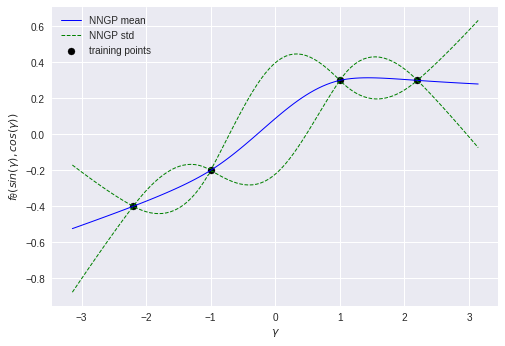

In [0]:
plt.scatter(input_train, target_train, color='black',label = 'training points')
plt.plot(input_test, mean_star, color='blue',
           linestyle='-', alpha = 1,  label = 'NNGP mean', linewidth = 1)
plt.plot(input_test, mean_star+2*stdv, color='green',
           linestyle='--', alpha = 1,  label = 'NNGP std', linewidth = 1)
plt.plot(input_test, mean_star-2*stdv, color='green',
           linestyle='--', alpha = 1, linewidth = 1)
plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.show()

**Analytic Tangent Kernel (should be added to the script instead)**

In [0]:
class Tangent(object):

    def __init__(self, input_dim, num_steps,
                 variance=1.0, bias_variance=0., active_dims=None):
        #gpflow.kernels.Kern.__init__(self, input_dim, active_dims)
        self.input_dim =input_dim
        self.num_steps = num_steps
        self.bias_variance=bias_variance
        self.variance=variance
        #self.variance = gpflow.param.Param(variance, gpflow.transforms.positive)
        #self.bias_variance = gpflow.param.Param(bias_variance, gpflow.transforms.positive)
    
    def baseK(self, X, X2):
        inner = torch.matmul(X * self.variance, X2.t())/self.input_dim 
        return inner + torch.ones_like(inner) * self.bias_variance
      
        
    def baseKdiag(self, X):
        inner = torch.sum(torch.mul(X,X) * self.variance, 1)/self.input_dim
        return inner + torch.ones_like(inner) * self.bias_variance
    
    def NTK(self,X,X2=None):
      
        # initialisation
        if X2 is None:
          X2 = X
        NTK = self.baseK( X, X2 )  # because NTK^1 = K^1
        ntkxdiag  = self.baseKdiag(X)
        ntkx2diag = self.baseKdiag(X2) 
        
        K = self.baseK( X, X2 )
        kxdiag  = self.baseKdiag(X)
        kx2diag = self.baseKdiag(X2) 
        
        # recursion
        for step_index in range(self.num_steps):
          # recursively compute (scaled) relu kernel
          K_new = self.recurseK( K, kxdiag, kx2diag )
          kxdiag_new = self.recurseKdiag( kxdiag )
          kx2diag_new = self.recurseKdiag( kx2diag )
          NTK = self.recurseNTK( NTK, ntkxdiag, ntkx2diag, K,kx2diag,kxdiag, K_new, kx2diag_new, kxdiag_new )
          ntkxdiag = self.recurseNTKdiag( ntkxdiag )
          kx2diag = self.recurseNTKdiag( ntkx2diag )
          K = K_new
          kxdiag = kxdiag_new
          kx2diag = kx2diag_new
           
        return NTK
        
    def K(self, X, X2=None):
        # the linear kernel
        if X2 is None:
            X2 = X
        K = self.baseK( X, X2 )
        kxdiag  = self.baseKdiag(X)
        kx2diag = self.baseKdiag(X2) 

        for step_index in range(self.num_steps):
            # recursively compute (scaled) relu kernel
            K = self.recurseK( K, kxdiag, kx2diag )
            kxdiag = self.recurseKdiag( kxdiag )
            kx2diag = self.recurseKdiag( kx2diag )

        return K

    def Kdiag(self, X):
        Kdiag = self.baseKdiag( X )

        for step_index in range(self.num_steps):
            Kdiag = self.recurseKdiag( Kdiag )

        return Kdiag

    def recurseK(self, K, kxdiag, kx2diag):
        norms = torch.sqrt(kxdiag)
        norms_rec = torch.rsqrt(kxdiag)
        norms2 = torch.sqrt(kx2diag)
        norms2_rec = torch.rsqrt(kx2diag)
        
        jitter = 1e-7
        scaled_numerator = K * (1.-jitter)
        
                
        cos_theta = scaled_numerator * norms_rec[:,None] *  norms2_rec[None,:]
        theta = torch.acos(cos_theta) 
        return self.variance / np.pi * (torch.sqrt(kxdiag[:,None] * kx2diag[None,:] - torch.mul(scaled_numerator,scaled_numerator) ) + (np.pi - theta) * scaled_numerator ) + self.bias_variance*torch.ones_like(K)
    
    def recurseNTK(self, NTK, ntkxdiag, ntkx2diag, K,kx2diag,kxdiag, K_new, kx2diag_new, kxdiag_new):
        norms = torch.sqrt(kxdiag)
        norms_rec = torch.rsqrt(kxdiag)
        norms2 = torch.sqrt(kx2diag)
        norms2_rec = torch.rsqrt(kx2diag)
        
        jitter = 1e-7
        scaled_numerator = K * (1.-jitter)
        
                
        cos_theta = scaled_numerator * norms_rec[:,None] *  norms2_rec[None,:]
        theta = torch.acos(cos_theta) 
        return K_new + self.variance * NTK * (np.pi - theta)
    
    
    def recurseKdiag(self, Kdiag):
        # angle is zero, hence the diagonal stays the same (if scaled relu is used)        
        return self.variance * Kdiag  + self.bias_variance * torch.ones_like(Kdiag)
    
    def recurseNTKdiag(self, Kdiag):
        # angle is zero, hence the diagonal stays the same (if scaled relu is used)        
        return self.variance * Kdiag  + self.bias_variance * torch.ones_like(Kdiag)

** test analytical tangent kernel**

In [0]:
bias_variance = 0.5
variance = 0.7
num_hidden_layers = 4
print("\n Test one dim: \n")
input_dim = 1
X = torch.from_numpy(np.atleast_2d( np.linspace( -0.5 , 0.5 , 4 ) ).T)
test_kernel = Tangent(input_dim = input_dim, num_steps = num_hidden_layers, variance=variance, bias_variance = bias_variance)
a=test_kernel.NTK(X,X)
print(a)


 Test one dim: 

tensor([[36.1653, 26.8128, 20.1487, 15.9469],
        [26.8128, 30.8496, 24.4792, 20.1487],
        [20.1487, 24.4792, 30.8496, 26.8128],
        [15.9469, 20.1487, 26.8128, 36.1653]], dtype=torch.float64)


**neural network at time t**

In [0]:
t= 10000000
eta = 0.1
bias_variance = 0.5
variance = 0.7
num_hidden_layers = 4
n_test = 100
print("\n Test one dim: \n")
input_dim = 1
input_train = np.array([-2.2, -1, 1, 2.2]) 
input_test = np.linspace( -np.pi , np.pi , n_test ) 
target_train = np.array([-0.4, -0.2, 0.3, 0.3])

X = torch.from_numpy(np.atleast_2d(input_train).T)
Y = torch.from_numpy(np.atleast_2d(target_train).T)
X_star = torch.from_numpy(np.atleast_2d(input_test).T)

kernel = Tangent(input_dim = input_dim, num_steps = num_hidden_layers, variance=variance, bias_variance = bias_variance)

NTK_star = kernel.NTK(X_star,X)
NTK_ss = kernel.NTK(X_star,X_star)
NTK = kernel.NTK(X,X)

# using https://github.com/RInterested/SIMULATIONS_and_PROOFS/blob/master/Gaussian%20process%20in%20Python%20and%20R 
# mean
L_NTK = np.linalg.cholesky(NTK.numpy())   #+ jitter? 0.00005 * np.eye(4)
NTK_s = NTK_star.t()
L_help = np.linalg.solve(L_NTK, NTK_s)  # 4 x 100
mat = np.eye(4)-scipy.linalg.expm(-eta*t*NTK.numpy())
Y_transf = mat.dot(Y)
meanNTK_star = np.dot(L_help.T, np.linalg.solve(L_NTK, Y_transf)).reshape((n_test,))


# variance
Ks_transf = np.matmul(mat,K_s)
K_transf = np.matmul(mat,L)
NTK_transf = np.matmul(mat,NTK_s)
L_help2 = np.linalg.solve(L_NTK, L) # Results in a (5, 50) matrix corresponding to L^{-1} K_s

term1 = np.diag(K_ss)

term2 = np.diag(-2*np.matmul(L_help.T, np.linalg.solve(L_NTK, Ks_transf)))

term31 = np.dot(L_help.T, np.linalg.solve(L_NTK, K_transf))
term32 = np.dot(L_help2.T, np.linalg.solve(L_NTK, NTK_transf))

s2 = term1+term2 +np.diag(np.matmul(term31,term32))
stdv = np.sqrt(s2)
#s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
#stdv = np.sqrt(s2)


 Test one dim: 



**plot at time t**

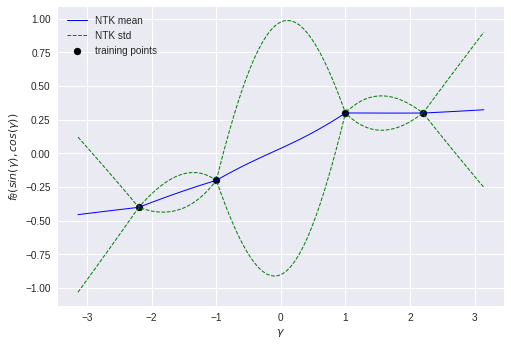

In [0]:
plt.scatter(input_train, target_train, color='black',label = 'training points')
plt.plot(input_test, meanNTK_star, color='blue',
           linestyle='-', alpha = 1,  label = 'NTK mean', linewidth = 1)
plt.plot(input_test, meanNTK_star+2*stdv, color='green',
           linestyle='--', alpha = 1,  label = 'NTK std', linewidth = 1)
plt.plot(input_test, meanNTK_star-2*stdv, color='green',
           linestyle='--', alpha = 1, linewidth = 1)
plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.show()